In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../Data/Housing.csv")
print(df.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


# Data Preprocessing
First, we need to convert categorical variables into numerical format:
- Binary variables (yes/no) will be converted to 1/0
- Furnishing status will be encoded using one-hot encoding

In [2]:
# Convert binary variables to 0/1
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_columns:
    df[col] = (df[col] == 'yes').astype(int)

# One-hot encode furnishing status
df = pd.get_dummies(df, columns=['furnishingstatus'], prefix='furnishing')

# Feature Selection and Target Variable
We'll separate our features and target variable:
- Target: price
- Features: all other columns

In [3]:
# Separate features and target
y = df['price'].values.astype(np.float64)
X = df.drop('price', axis=1).values.astype(np.float64)

# Min-Max Scaling
Scale the features to a range of [0,1] using Min-Max scaling

In [4]:
# Apply Min-Max scaling for features
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_minmax = (X - X_min) / (X_max - X_min)

# Apply Min-Max scaling for target
y_min = y.min()
y_max = y.max()
y_minmax = (y - y_min) / (y_max - y_min)

# Add bias term
X_minmax = np.c_[np.ones(X_minmax.shape[0]), X_minmax]

# Standard Scaling
Scale the features using standardization (mean=0, std=1)

In [5]:
# Apply Standard scaling for features
X_mean = X.mean(axis=0)
X_std = np.std(X, axis=0)  # Using numpy's std function directly
X_standard = (X - X_mean) / X_std

# Apply Standard scaling for target
y_mean = y.mean()
y_std = np.std(y)
y_standard = (y - y_mean) / y_std

# Add bias term
X_standard = np.c_[np.ones(X_standard.shape[0]), X_standard]

# Outlier Removal using Z-Score
We use the z-score method to remove outliers from our dataset:
- Calculate z-scores for each feature
- Remove data points where any feature has |z-score| > 3
- This assumes the data follows a normal distribution
- Points with z-score > 3 are considered outliers as they lie beyond 3 standard deviations

In [6]:
# Calculate z-scores for features
z_scores = np.abs((X - X_mean) / X_std)
print(f"Z-scores shape: {z_scores.shape}")

# Remove outliers (points with z-score > 3)
non_outliers_mask = (z_scores < 3).all(axis=1)
print(f"Number of outliers removed: {np.sum(~non_outliers_mask)}")

# Apply outlier removal to both scaled datasets and their respective scaled targets
X_cleaned_minmax = X_minmax[non_outliers_mask]
X_cleaned_standard = X_standard[non_outliers_mask]
y_cleaned_minmax = y_minmax[non_outliers_mask]
y_cleaned_standard = y_standard[non_outliers_mask]

print(f"Cleaned X shape: {X_cleaned_minmax.shape}")
print(f"Cleaned y shape: {y_cleaned_minmax.shape}")

Z-scores shape: (545, 14)
Number of outliers removed: 42
Cleaned X shape: (503, 15)
Cleaned y shape: (503,)


# Model Training and Comparison
We use batch gradient descent to train two linear regression models:
1. One with Min-Max scaled features
2. One with Standardized features

The comparison of Mean Squared Error (MSE) between the two models will help us understand which scaling technique works better for this specific dataset.

In [7]:
def batch_gradient_descent(x, y, lr=0.01, epochs=100):
    weights = np.zeros(x.shape[1])
    loss_history = []
    
    for epoch in range(epochs):
        predictions = x @ weights
        errors = predictions - y
        mse = np.mean(errors ** 2)
        gradient = (2 / len(y)) * x.T @ errors
        weights -= lr * gradient
        
        # Store loss history
        loss_history.append(mse)
        
    return weights, np.array(loss_history)

# Train the models with scaled targets
weights1, loss_history1 = batch_gradient_descent(X_cleaned_minmax, y_cleaned_minmax)
weights2, loss_history2 = batch_gradient_descent(X_cleaned_standard, y_cleaned_standard)

# Predict
y_pred_minmax = X_cleaned_minmax @ weights1
y_pred_standard = X_cleaned_standard @ weights2

# Calculate MSE on scaled values
mse_minmax_scaled = np.mean((y_cleaned_minmax - y_pred_minmax) ** 2)
mse_standard_scaled = np.mean((y_cleaned_standard - y_pred_standard) ** 2)

# Convert predictions back to original scale for interpretation
y_pred_minmax_original = y_pred_minmax * (y_max - y_min) + y_min
y_pred_standard_original = y_pred_standard * y_std + y_mean

# Output results
print("Weights after Min-Max Scaling:", weights1)
print("Weights after Standard Scaling:", weights2)
print(f"MSE after Min-Max Scaling (scaled values): {mse_minmax_scaled:.7f}")
print(f"MSE after Standard Scaling (scaled values): {mse_standard_scaled:.7f}")

Weights after Min-Max Scaling: [0.07613784 0.03280089 0.0388571  0.02189749 0.04649454 0.07351189
 0.02969311 0.03184998 0.         0.06536849 0.03548633 0.04115215
 0.03651831 0.03603719 0.00358233]
Weights after Standard Scaling: [-0.02373423  0.24418918  0.07785229  0.21256192  0.19073316  0.08451274
  0.09000183  0.05489992  0.00520407  0.21606252  0.12500566  0.14805633
  0.04163747  0.03194155 -0.07236797]
MSE after Min-Max Scaling (scaled values): 0.0121252
MSE after Standard Scaling (scaled values): 0.2976820


# Loss Comparison Visualization
The following plot shows how the Mean Squared Error (MSE) changes during training for both scaling methods. This helps us understand:
- The convergence speed of each method
- The stability of the training process
- The final loss achieved by each scaling technique

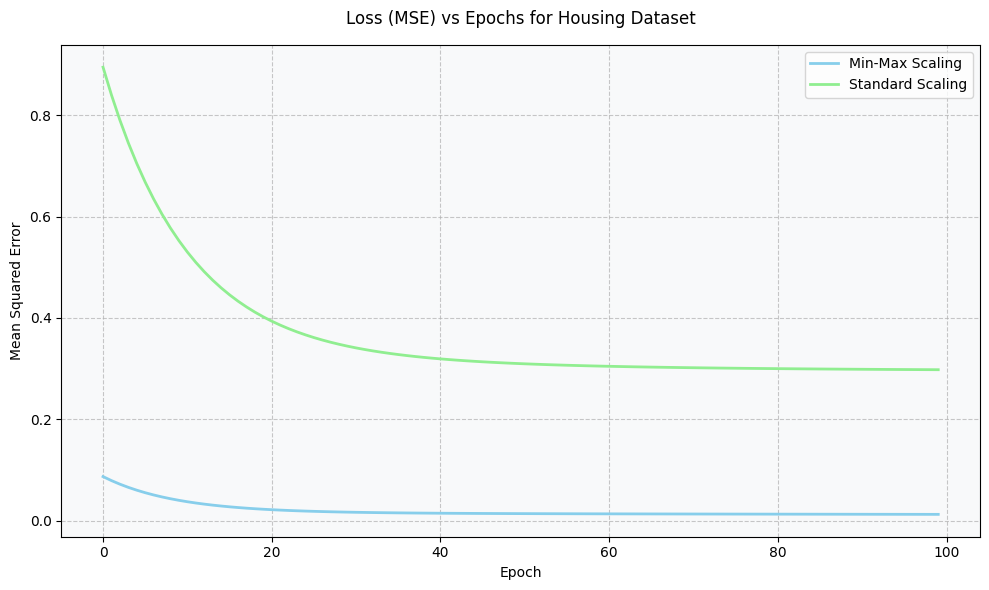

In [8]:
import matplotlib.pyplot as plt

# Create figure
plt.figure(figsize=(10, 6))

# Plot Loss History
plt.plot(loss_history1, label='Min-Max Scaling', color='skyblue', linewidth=2)
plt.plot(loss_history2, label='Standard Scaling', color='lightgreen', linewidth=2)

# Customize the plot
plt.title('Loss (MSE) vs Epochs for Housing Dataset', fontsize=12, pad=15)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a light gray background grid for better readability
plt.gca().set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()